In [3]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    !kaggle datasets download -d sixhky/open-images-bus-trucks/
    !unzip -qq open-images-bus-trucks.zip
    !rm open-images-bus-trucks.zip

 99%|███████████████████████████████████████▍| 362M/367M [00:15<00:00, 35.2MB/s]
100%|████████████████████████████████████████| 367M/367M [00:15<00:00, 24.6MB/s]


In [4]:
from torch_snippets import *
from PIL import Image
IMAGE_ROOT = 'images/images'
DF_RAW = df = pd.read_csv('df.csv')

In [5]:
label2target = {l:t+1 for t,l in \
                enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [6]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [8]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), \
                              resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        # Convert to absolute coordinates
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h 
        boxes = data.astype(np.uint32).tolist() 
        # torch FRCNN expects ground truths as 
        # a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] \
                                for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [9]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), \
                    test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], \
                    df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, \
            collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, \
            collate_fn=test_ds.collate_fn, drop_last=True)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection\
                .fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor\
                       .cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [14]:
# Defining training and validation functions 
def train_batch(inputs, model, optimizer):
    model.train()
    inp, targets = inputs
    inp = list(image.to(device) for image in inp)
    targets = [{k: v.to(device) for k, v \
                in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(inp, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() 
def validate_batch(inputs, model):
    model.train() 
#to obtain losses, model needs to be in train mode only
#Note that here we arn't defining the model's forward method 
#hence need to work per the way the model class is defined
    inp, targets = inputs
    inp = list(image.to(device) for image in inp)
    targets = [{k: v.to(device) for k, v \
                in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(inp, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses


In [15]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, \
                            momentum=0.9,weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

In [16]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, \
            loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier', \
                'loss_box_reg', 'loss_objectness', \
                'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), \
                 trn_loc_loss=loc_loss.item(), \
                 trn_regr_loss=regr_loss.item(), \
                 trn_objectness_loss=loss_objectness.item(), \
               trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), \
                 end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, \
            loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier', \
                'loss_box_reg', 'loss_objectness', \
                'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), \
                 val_loc_loss=loc_loss.item(), \
                 val_regr_loss=regr_loss.item(), \
                val_objectness_loss=loss_objectness.item(), \
               val_rpn_box_reg_loss=loss_rpn_box_reg.item(), \
                 end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.186	trn_loc_loss: 0.077	trn_regr_loss: 0.083	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.008	val_loss: 0.171	val_loc_loss: 0.069	val_regr_loss: 0.078	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.009	(977.65s - 3910.58s remaining)
EPOCH: 2.000	trn_loss: 0.155	trn_loc_loss: 0.064	trn_regr_loss: 0.074	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.007	val_loss: 0.173	val_loc_loss: 0.071	val_regr_loss: 0.079	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.009	(1901.26s - 2851.89s remaining)
EPOCH: 3.000	trn_loss: 0.144	trn_loc_loss: 0.059	trn_regr_loss: 0.071	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.007	val_loss: 0.178	val_loc_loss: 0.072	val_regr_loss: 0.081	val_objectness_loss: 0.017	val_rpn_box_reg_loss: 0.009	(2790.47s - 1860.31s remaining)
EPOCH: 4.000	trn_loss: 0.141	trn_loc_loss: 0.058	trn_regr_loss: 0.069	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.007	val_loss: 0.188	val_loc_loss: 0.077	val_regr_loss: 0.084	val_objectne

  0%|          | 0/6 [00:00<?, ?it/s]/home/pedro/anaconda3/envs/science/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pedro/anaconda3/envs/science/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:00<00:00, 320.27it/s]


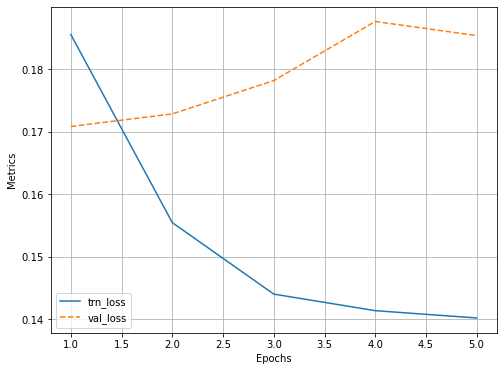

In [17]:
log.plot_epochs(['trn_loss','val_loss'])

In [18]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = \
    output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in \
                output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), 
                            torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, \
                                            confs, labels]]

    if len(ixs) == 1:
        bbs,confs,labels = [np.array([tensor]) for tensor \
                                in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


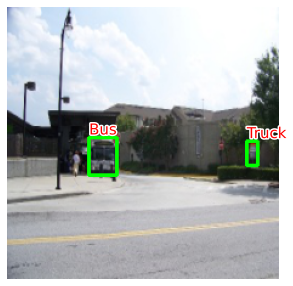

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


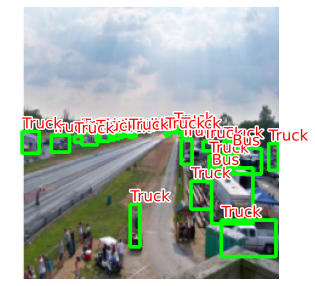

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


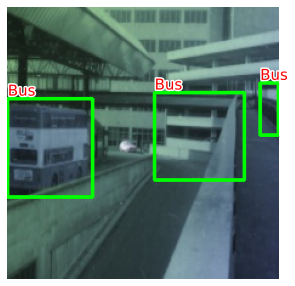

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


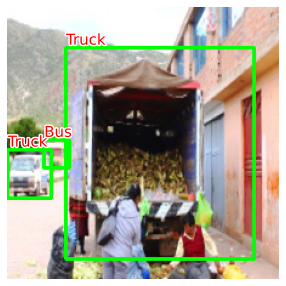

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


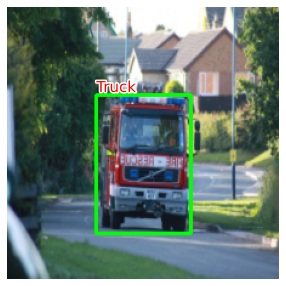

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


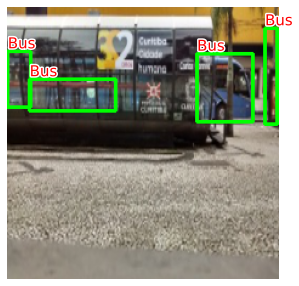

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


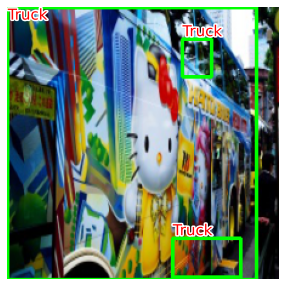

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


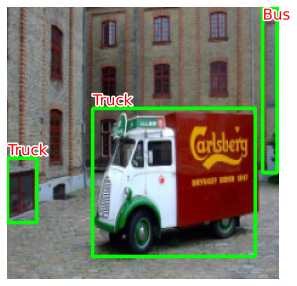

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


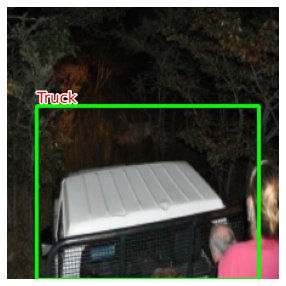

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


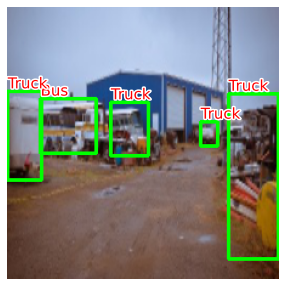

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


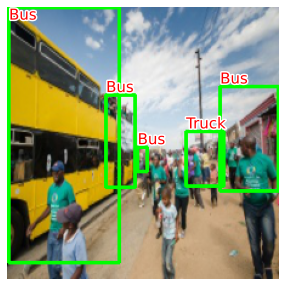

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


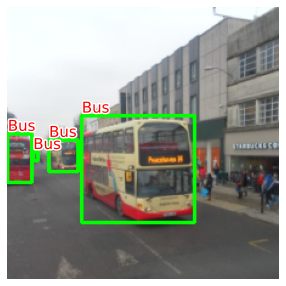

In [19]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, \
                texts=labels, sz=5)